In [1]:

# Submitted By: Krishnesh Mertia
#Obstacle Avoidance for a 2D Quadrotor Using ILQR

In [2]:
# JAI SHRI SHYAM
#Importing Libraries
from sympy.utilities.lambdify import lambdify
from pylab import *
import time
from sympy import exp, sqrt
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.interpolate
import matplotlib.animation
np.set_printoptions(precision=5,linewidth=120,suppress=True)
from sympy import sin, cos, Matrix
from sympy import Symbol
from sympy import symbols
from sympy import init_printing
init_printing(use_unicode=True)
from pylab import *
import scipy.interpolate
import matplotlib.animation
np.set_printoptions(precision=5,linewidth=120,suppress=True)
from sympy.utilities.lambdify import lambdify
from sympy import sin, cos, Matrix
from sympy import exp, sqrt

In [3]:
# Creating the Animation Function
# Few Parts of Animation function are taken from
#@misc{flashlight:2016,
#    author       = {Mike Roberts},
#    title        = {Flashlight: A Python Library for Analyzing and Solving Quadrotor Control Problems},
#year         = {2016},
#    howpublished = {\url{http://mikeroberts3000.github.io/flashlight}}
#}
def interp1d_vector_wrt_scalar(t,x,kind="linear"):

    interp1d_funcs = []

    for d in range(x.shape[1]):
        interp1d_funcs.append(scipy.interpolate.interp1d(t,matrix(x[:,d]).A1,kind=kind))

    def interp1d_vector_wrt_scalar_func(t):
        t    = matrix(t).astype(float64).A1
        vals = zeros((t.shape[0],len(interp1d_funcs)))
        for d in range(len(interp1d_funcs)):
            vals[:,d] = interp1d_funcs[d](t)
        if t.shape[0] == 1:
            return matrix(vals).T
        else:
            return vals

    return interp1d_vector_wrt_scalar_func
def animate_fun(t, x, x_nominal):
    import matplotlib.animation
    d=0.5
    x_nominal_interp_func =interp1d_vector_wrt_scalar(t, x_nominal, kind="cubic")
    p_nominal = x_nominal[:,0:2]
   # x_interp_func = interp1d_vector_wrt_scalar(t, x, kind="linear")
    p = x[:,0:2]
    theta = x[:,2]
    p_0_y       = p[:,0] + d*(np.sin(theta+pi))
    p_0_x       = p[:,1] + d*np.cos(theta+pi)
    p_1_y       = p[:,0] + d*np.sin(theta)
    p_1_x       = p[:,1] + d*np.cos(theta)
    offset_up_y = 0.2*np.sin(theta+(pi/2.0))
    offset_up_x = 0.2*np.cos(theta+(pi/2.0))
    offset_up = matrix(c_[offset_up_y, offset_up_x])
    p_0       = matrix(c_[p_0_y, p_0_x])
    p_1       = matrix(c_[p_1_y, p_1_x])
    p_0_up    = p_0 + offset_up
    p_1_up    = p_1 + offset_up
    rc("animation", html="html5")
    fig = figure(figsize=(10,10))
    ax  = fig.add_subplot(111, autoscale_on=False, xlim=(-5, 15), ylim=(-0,10))
    ax.set_aspect("equal")
    ax.grid()
    plt.close()
    plz, = ax.plot([],[])
    plz1,= ax.plot([],[])
    plz2,= ax.plot([],[])
    plz3,= ax.plot([],[])        
    ax.plot(p_nominal[:,1], p_nominal[:,0])
    p_nominal_plot, = ax.plot([], [])
    p0_p1_line,          = ax.plot([], [], "o-", lw=2)
    p0_pup0_line,        = ax.plot([], [], "o-", lw=2)
    p1_pup1_line,        = ax.plot([], [], "o-", lw=2)
    time_text            = ax.text(0.05, 0.95, "", transform=ax.transAxes)
    debug_text           = ax.text(0.05, 0.90, "", transform=ax.transAxes)
    time_text_template   = "t = %.1fs"
    debug_text_template  = "E = %.1fJ, T = %.1fJ, U = %.1fJ"

    def init():
        return plz,plz1,plz2,plz3,p_nominal_plot, p0_p1_line, p0_pup0_line, p1_pup1_line, time_text, debug_text

    def animate(i):
        t_i = t[i]
        x_nominal_current = x_nominal_interp_func(t_i).T.A
        p_nominal_current = x_nominal_current[:,0:2]
        p_nominal_plot.set_data(p_nominal_current[:,1], p_nominal_current[:,0])
       
        px_plz = linspace(3,6,100)
        py_plz = np.ones(100)*3
        plz.set_data(px_plz,py_plz)
        px1_plz = linspace(3,6,100)
        py1_plz = np.ones(100)*6
        plz1.set_data(px1_plz,py1_plz)
        py2_plz = linspace(3,6,100)
        px2_plz = np.ones(100)*3
        plz2.set_data(px2_plz,py2_plz)
        py3_plz = linspace(3,6,100)
        px3_plz = np.ones(100)*6
        plz3.set_data(px3_plz,py3_plz)

        p0_p1_y_current = [p_0[i,0], (p_0[i,0]+p_1[i,0])/2.0, p_1[i,0]]
        p0_p1_x_current = [p_0[i,1], (p_0[i,1]+p_1[i,1])/2.0, p_1[i,1]]
        p0_p1_line.set_data(p0_p1_x_current, p0_p1_y_current)

        p0_pup0_y_current = [p_0[i,0], p_0_up[i,0]]
        p0_pup0_x_current = [p_0[i,1], p_0_up[i,1]]
        p0_pup0_line.set_data(p0_pup0_x_current, p0_pup0_y_current)

        p1_pup1_y_current = [p_1[i,0], p_1_up[i,0]]
        p1_pup1_x_current = [p_1[i,1], p_1_up[i,1]]
        p1_pup1_line.set_data(p1_pup1_x_current, p1_pup1_y_current)

        time_text.set_text(time_text_template % t_i)
        debug_text.set_text("")
        return plz,plz1,plz2,plz3,p_nominal_plot, p0_p1_line, p0_pup0_line, p1_pup1_line, time_text, debug_text

    animation = matplotlib.animation.FuncAnimation(fig, animate, arange(t.shape[0]), interval=25, blit=True, init_func=init)

    
    return animation

In [4]:
# state = [x,y,angle,x_dot,y_dot,omega]
x0,x1,x2,x3,x4,x5,u0,u1,g,m,I = symbols('x0 x1 x2 x3 x4 x5 u0 u1 g m I')
# Making continuous dynamics for Quadrotor(Symbolic)
def continous_dym_sym():
    state = Matrix
    x_dot_term_left = Matrix([[x3],[x4],[x5],[0],[-g],[0]])
    x_dot_term_right = Matrix([[0],[0],[0],[-u0/m*sin(x2)],[u0/m*cos(x2)],[u1/I]])
    x_dot = x_dot_term_left + x_dot_term_right
    return(x_dot.T)
f_cont = lambdify((x0,x1,x2,x3,x4,x5,u0,u1,g,m,I),continous_dym_sym(),'numpy')
# Making discrete dynamics for Quadrotor(Symbolic)
def discrete_dynamics_sym():
    dt = 0.01
    x = Matrix([[x0], [x1], [x2], [x3], [x4],[x5]])
    x_next = x.T + dt*continous_dym_sym()
    return x_next
f_nx = lambdify((x0,x1,x2,x3,x4,x5,u0,u1,g,m,I),discrete_dynamics_sym(),'numpy')
# Computing jacobian for the dynamics
def continous_jacobian_sym():
    x_j = discrete_dynamics_sym()
    x_d = Matrix([[x0], [x1], [x2], [x3], [x4],[x5]])
    A = x_j.jacobian(x_d)
    u_d = Matrix([[u0],[u1]])
    B = x_j.jacobian(u_d)
    return A,B
A,B = continous_jacobian_sym()
f_A = lambdify((x0,x1,x2,x3,x4,x5,u0,u1,g,m,I),A,'numpy')
f_B = lambdify((x0,x1,x2,x3,x4,x5,u0,u1,g,m,I),B,'numpy')
# Cost to Go 
def cost_stage_sym():
    Q = diag([1,1,1,1,1,1])
    state_vec = Matrix([x0-5 , x1-10, x2+1,x3,x4,x5]) 
    state = state_vec.T*Q*state_vec
    c_control= Matrix([(u0**2 + u1**2)*0.1])
    c_obstacle =  Matrix([1000*(exp((-sqrt((x0-4.5)**2 + (x1-4.5)**2 ))))])
    stage_cost =state + c_control + c_obstacle
    return stage_cost
f_cs = lambdify((x0,x1,x2,x3,x4,x5,u0,u1,g,m,I),cost_stage_sym(),'numpy')
# Terminal Cost
def cost_final_sym():
    Q = diag([1,1,1,1,1,1])
    Q = Q*50000
    state_vec = Matrix([x0-5 , x1-10, x2,x3,x4,x5])
    final_cost = state_vec.T*Q*state_vec
    return final_cost 
f_cf = lambdify((x0,x1,x2,x3,x4,x5,g,m,I),cost_final_sym(),'numpy')
#Computing Jacobian for cost to go 
def cost_stage_jac_sym():
    c_s_j = cost_stage_sym()
    x_d = Matrix([[x0], [x1], [x2], [x3], [x4],[x5]])
    u_d = Matrix([[u0],[u1]])
    c_x = c_s_j.jacobian(x_d)
    c_u = c_s_j.jacobian(u_d)
    c_xx = c_x.jacobian(x_d)
    c_uu = c_u.jacobian(u_d)
    c_ux = c_u.jacobian(x_d)
    return c_x, c_u, c_xx, c_uu, c_ux
c_x, c_u, c_xx, c_uu, c_ux = cost_stage_jac_sym()
f_c_x = lambdify((x0,x1,x2,x3,x4,x5,u0,u1,g,m,I),c_x,'numpy')
f_c_u = lambdify((x0,x1,x2,x3,x4,x5,u0,u1,g,m,I),c_u,'numpy')
f_c_xx = lambdify((x0,x1,x2,x3,x4,x5,u0,u1,g,m,I),c_xx,'numpy')
f_c_uu = lambdify((x0,x1,x2,x3,x4,x5,u0,u1,g,m,I),c_uu,'numpy')
f_c_ux = lambdify((x0,x1,x2,x3,x4,x5,u0,u1,g,m,I),c_ux,'numpy')
#Computing Jacobian for Terminal Cost
def cost_final_jac_sym():
    c_s_f = cost_final_sym()
    x_d = Matrix([[x0], [x1], [x2], [x3], [x4],[x5]])
    c_x_f = c_s_f.jacobian(x_d)
    c_xx_f = c_x_f.jacobian(x_d)
    return c_x_f, c_xx_f
c_x_f, c_xx_f = cost_final_jac_sym()
f_c_x_f = lambdify((x0,x1,x2,x3,x4,x5,u0,u1,g,m,I),c_x_f,'numpy')
f_c_xx_f = lambdify((x0,x1,x2,x3,x4,x5,u0,u1,g,m,I),c_xx_f,'numpy')

c_x, c_u, c_xx, c_uu, c_ux = cost_stage_jac_sym()

In [5]:
# Calculating the trajectory when given the control input
def traj_cal(xint,u_trj):
    x_trj = np.zeros((u_trj.shape[0]+1,x0.shape[0]))
    x_trj[0,:] = xint
    for i in range(u_trj.shape[0]):
        u = u_trj[i,:]
        xint = f_nx(xint[0],xint[1],xint[2],xint[3],xint[4],xint[5],u[0],u[1],9.8,1,1)
        xint = xint[0]
        x_trj[i+1,:] =xint
    return x_trj
# Calculating Cost for using the State and control
def cost(x, u):
    total = 0.0
    for i in range(u.shape[0]):
        xint = x[i,:] 
        uint = u[i,:]         
        total = f_cs(xint[0],xint[1],xint[2],xint[3],xint[4],xint[5],uint[0],uint[1],9.8,1,1) + total
    xint = x[-1,:]
    total = total + f_cf(xint[0],xint[1],xint[2],xint[3],xint[4],xint[5],9.8,1,1)
    return total[0]

In [6]:
# Calculating the Q terms 
def Q_terms(j_x, j_u, j_xx, j_ux, j_uu, f_x, f_u, S_x, S_xx):
    Q_x = j_x.T + S_x.dot(f_x)
    Q_u = j_u.T + S_x.dot(f_u)
    Q_xx = j_xx + (f_x.T).dot(S_xx).dot(f_x)
    Q_ux = j_ux + (f_u.T).dot(S_xx).dot(f_x)
    Q_uu = j_uu + (f_u.T).dot(S_xx).dot(f_u)
    return Q_x, Q_u, Q_xx, Q_ux, Q_uu
# Calculating the Gains
def gains(Q_uu, Q_u, Q_ux):
    Q_uu_inv = np.linalg.inv(Q_uu)
    k = - Q_uu_inv.dot(Q_u)
    K = - Q_uu_inv.dot(Q_ux)
    return k, K
# Calculating the S terms 
def S_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k):
    S_x = Q_x + (K.T).dot(Q_uu).dot(k)+ (K.T).dot(Q_u)+(Q_ux.T).dot(k)
    S_xx = Q_xx + (K.T).dot(Q_uu).dot(K)+(K.T).dot(Q_ux)+(Q_ux.T).dot(K)
    return S_x, S_xx
# Forward Pass
def forward_pass(x_traj, u_traj, k_traj, K_traj,alpha):
    x_traj_new = np.zeros(x_traj.shape)
    x_traj_new[0,:] = x_traj[0,:]
    u_traj_new = np.zeros(u_traj.shape)
    for n in range(u_traj.shape[0]):
        u_traj_new[n,:] = u_traj[n,:] + alpha*k_traj[n,:] + (K_traj[n,:]).dot(x_traj_new[n,:] - x_traj[n,:])
        u = u_traj_new[n,:]
        xint = x_traj_new[n,:]
        x_traj_new[n+1,:] = f_nx(xint[0],xint[1],xint[2],xint[3],xint[4],xint[5],u[0],u[1],9.8,1,1)
    return x_traj_new, u_traj_new
# Backward Pass
def backward_pass(x_traj, u_traj):
    k_traj = np.zeros([u_traj.shape[0], u_traj.shape[1]])
    K_traj = np.zeros([u_traj.shape[0], u_traj.shape[1], x_traj.shape[1]])
    expected_cost_redu = 0
    S_xx = diag([1,1,1,1,1,1]) *50                 # for terminal
    S_x = diag([1,1,1,1,1,1]).dot(np.array([15,15,0,0,0,0]).T - x_traj[-1,:])   # for terminal
    for n in range(u_traj.shape[0]-1, -1, -1):
        xint = x_traj[n,:] 
        uint = u_traj[n,:] 
        k_c_x = f_c_x(xint[0],xint[1],xint[2],xint[3],xint[4],xint[5],uint[0],uint[1],9.8,1,1)
        k_c_x = k_c_x[0]
        k_c_u = f_c_u(xint[0],xint[1],xint[2],xint[3],xint[4],xint[5],uint[0],uint[1],9.8,1,1)
        k_c_u = k_c_u[0]
        k_c_xx = f_c_xx(xint[0],xint[1],xint[2],xint[3],xint[4],xint[5],uint[0],uint[1],9.8,1,1)
        k_c_ux = f_c_ux(xint[0],xint[1],xint[2],xint[3],xint[4],xint[5],uint[0],uint[1],9.8,1,1)
        k_c_uu = f_c_uu(xint[0],xint[1],xint[2],xint[3],xint[4],xint[5],uint[0],uint[1],9.8,1,1)
        k_c_A = f_A(xint[0],xint[1],xint[2],xint[3],xint[4],xint[5],uint[0],uint[1],9.8,1,1)
        k_c_B = f_B(xint[0],xint[1],xint[2],xint[3],xint[4],xint[5],uint[0],uint[1],9.8,1,1)
        Q_x, Q_u, Q_xx, Q_ux, Q_uu = Q_terms(k_c_x, k_c_u, k_c_xx, k_c_ux, k_c_uu, k_c_A, k_c_B, S_x, S_xx)
        k, K = gains(Q_uu, Q_u, Q_ux)
        k_traj[n,:] = k
        K_traj[n,:,:] = K
        S_x, S_xx = S_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k)
    return k_traj, K_traj, expected_cost_redu

In [9]:
def ilqr(x0,N ,iterations):
    # Initial control Trajectory
    u_int_v1 = np.ones([1,N])
    u_int_v1 = (u_int_v1)*9.8 + 2*9.8
    u_int_v2 = np.ones([1,N])
    u_int_v2 =u_int_v2*10*0
    u_trj = np.concatenate((u_int_v1, u_int_v2), axis=0)
    u_trj = u_trj.T
    x_trj = traj_cal(x0, u_trj)
    x_trj_gg = x_trj
    total_cost = cost(x_trj, u_trj)
    alpha = 1
    cost_list = [total_cost]  # Creating a list of cost funtion
    n= 0
    # Run main loop
    for it in range(iterations):
        # Backward pass and forward pass
        k_trj, K_trj, expected_cost_redu = backward_pass(x_trj, u_trj)
        x_trj_new, u_trj_new = forward_pass(x_trj, u_trj, k_trj, K_trj,alpha)
        # Evaluating the  new trajectory
        total_cost = cost(x_trj_new, u_trj_new)
        cost_redu = cost_list[-1] - total_cost
        if cost_redu > 0:
            cost_list.append(total_cost)
            x_trj = x_trj_new
            u_trj = u_trj_new       
        else:
            cost_list.append(cost_list[-1])
            alpha *= 0.9            # Applying line search 
        if total_cost<0:            # breaking out if cost<0
            break
    return x_trj_gg,x_trj, u_trj, cost_list

In [10]:
# setting up the ILQR Problem
x0 = np.array([5,0, 0,0, 0.0, 0.0]) # Initial positon for the quadrotor
N = 500                             #Horizon Length 
no_of_iter=6                        #No of iteration to perform
x_traj_gg,x_traj, u_traj, cost_list = ilqr(x0, N, no_of_iter)

In [11]:
dt = 0.01
t = linspace(0.0,dt*N,N+1)
animate_fun(t,x_traj,x_traj_gg)

Text(0.5, 1.0, 'Cost')

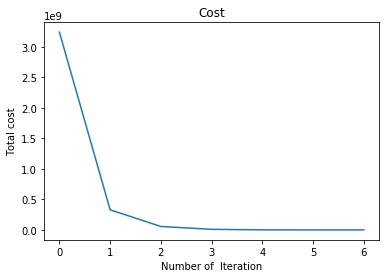

In [12]:
plt.plot(cost_list)
plt.xlabel('Number of  Iteration')
plt.ylabel('Total cost')
plt.title('Cost')

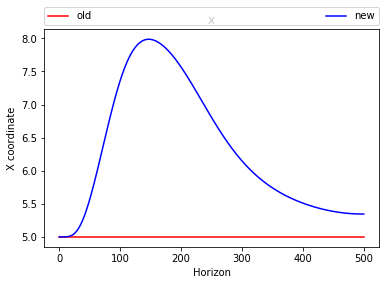

In [13]:
plt.plot(x_traj_gg[:,0],'r',label='old')

plt.plot(x_traj[:,0],'b',label='new')
plt.legend('New')
plt.xlabel('Horizon')
plt.ylabel('X coordinate')
plt.title('x')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)

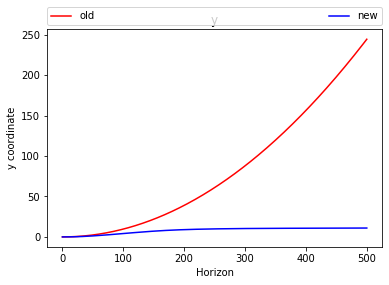

In [14]:
plt.plot(x_traj_gg[:,1],'r',label='old')
plt.plot(x_traj[:,1],'b',label='new')
plt.xlabel('Horizon')
plt.ylabel('y coordinate')
plt.title('y')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)

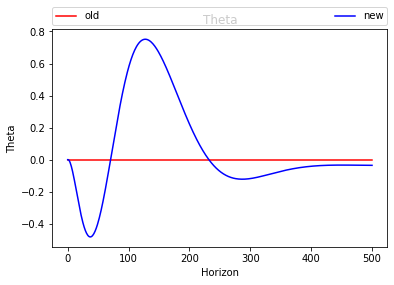

In [15]:
plt.plot(x_traj_gg[:,2],'r',label='old')
plt.plot(x_traj[:,2],'b',label='new')
plt.xlabel('Horizon')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)

Text(0.5, 1.0, 'Control 1')

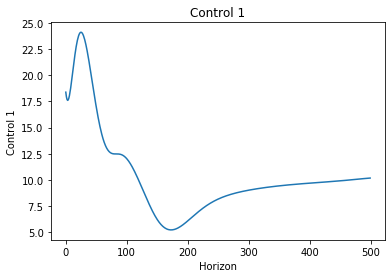

In [16]:
plt.plot(u_traj[:,0])
plt.xlabel('Horizon')
plt.ylabel('Control 1')
plt.title('Control 1')

Text(0.5, 1.0, 'Control 2')

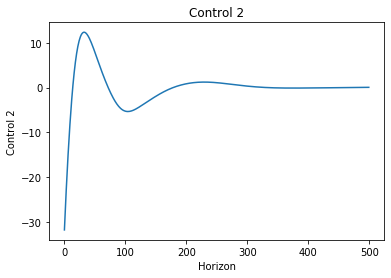

In [17]:
plt.plot(u_traj[:,1])
plt.xlabel('Horizon')
plt.ylabel('Control 2')
plt.title('Control 2')